## pangolulu/neural-network-from-scratch
https://github.com/pangolulu/neural-network-from-scratch

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

### gateモジュール
<img src="./GiHub_neural-network-from-scratch021.png" width="480" align="left">

### gate.py

In [1]:
import numpy as np

class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

### outputモジュール
- predictメソッド；Sortmax関数そのまま（確率を表す）
- lossメソッド；Sortmax関数の出力の内ターゲットと一致したものの自然対数（交差エントロピー誤差）
- diffメソッド；Sortmax関数の出力からターゲットと一致したものだけ１を減じる，これはSortmax関数の逆伝播である


### output.py

In [2]:
import numpy as np

class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

In [3]:
sss = Softmax()
X=np.array([1, 2]).reshape(1,-1)
y=np.array([1])
num_examples = X.shape[0]
probs = sss.predict(X)
corect_logprobs = -np.log(probs[range(num_examples), y])
data_loss = np.sum(corect_logprobs)
print(num_examples)
print(probs)
print(corect_logprobs)
print(data_loss)
print(sss.loss(X,y))
print(sss.diff(X,y))

1
[[ 0.26894142  0.73105858]]
[ 0.31326169]
0.313261687518
0.313261687518
[[ 0.26894142 -0.26894142]]


### layerモジュール
<img src="./GiHub_neural-network-from-scratch011.png" width="480" align="left">

### layer.py

In [4]:
import numpy as np

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

### mlnnモジュール
<img src="./GiHub_neural-network-from-scratch031.png" width="480" align="left">

- コンストラクタはレイヤーの数とレイヤーのサイズを決めている
- calculate_lossメソッドは損失関数を計算する，繰り返し1000回ごとにprintされるときに呼ばれる
- predictメソッドは予測値を計算する，予測結果の描画のときに呼ばれる
- trainメソッドは訓練である
    - 繰り返し数とハイパーパラメータを引数にしている
        - epsilon；学習率
        - reg_lambda；正則化強度
    - 繰り返しの1回で，
        - 順伝播では生のスコアを計算している
        - 逆伝播では勾配効果法の誤差の微分を計算している

### mlnn.py

In [5]:
import numpy as np
# from gate import MultiplyGate, AddGate
# from output import Softmax
# from layer import Tanh


class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 1000 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

### utilsモジュール
plot_decision_boundary関数；引数で予測値を受け取り，予測結果と決定領域を描画する

### utils.py

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

### mainモジュールの動作
1. 2ムーンのデータセットをつくる
2. mlnnモジュールのModelクラスをインスタンス化する（引数([2, 3, 2])でイニシャライズする）
3. Modelクラスのtainメソッドで訓練する
4. utilsモジュールのplot_decision_boundary関数で結果を描画する（引数に予測値を渡す）

### main.py

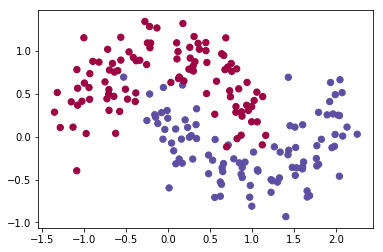

Loss after iteration 0: 0.700172
Loss after iteration 1000: 0.322746
Loss after iteration 2000: 0.192809
Loss after iteration 3000: 0.163425
Loss after iteration 4000: 0.161704
Loss after iteration 5000: 0.160966
Loss after iteration 6000: 0.160581
Loss after iteration 7000: 0.160361
Loss after iteration 8000: 0.160228
Loss after iteration 9000: 0.160146
Loss after iteration 10000: 0.160094
Loss after iteration 11000: 0.160060
Loss after iteration 12000: 0.160037
Loss after iteration 13000: 0.160022
Loss after iteration 14000: 0.160012
Loss after iteration 15000: 0.160005
Loss after iteration 16000: 0.160001
Loss after iteration 17000: 0.159997
Loss after iteration 18000: 0.159995
Loss after iteration 19000: 0.159994


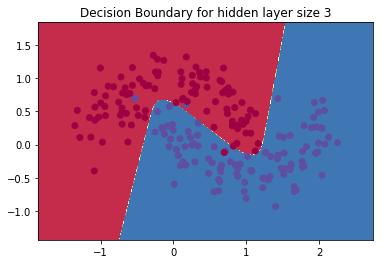

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
# import mlnn
# from utils import plot_decision_boundary

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
# plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.magma)
plt.show()

layers_dim = [2, 3, 2]

# model = mlnn.Model(layers_dim)
model = Model(layers_dim)
model.train(X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

## GitHubから
マルチレイヤニューラルネットワークの一からの実装
この投稿はhttp://www.wildml.com/2015/09/implementing-a- nural-network-from-scratchからインスピレーションを得ています。

この記事では、最初から複数層のニューラルネットワークを実装します。各層の層数と寸法をパラメータと見なすことができます。たとえば、[2, 3, 2]2次元の入力、3次元の1つの隠れ層、2次元の出力（2進分類）（出力としてsoftmaxを使用）を表します。

私たちは必要な数学をすべて導き出すことはしませんが、私たちが何をしているのかについて直感的に説明しようとします。私はあなたが詳細を読んだためのリソースも指します。

データセットの生成
まず、演奏できるデータセットを生成しましょう。幸いなことに、scikit-learnには有用なデータセットジェネレータがあるので、コードを自分で書く必要はありません。私たちは一緒に行きますmake_moonsの機能。

生成したデータセットには赤と青の2つのクラスがあります。私たちの目標は、x座標とy座標が与えられた正しいクラスを予測する機械学習分類器を訓練することです。データは直線的に分離できないので、2つのクラスを分離する直線を描くことはできません。これは、ロジスティック回帰などの線形分類器が、与えられたデータセットでうまく動作する非線形のフィーチャ（多項式など）を手作業で作成しない限り、データに適合できないことを意味します。

実際、これはニューラルネットワークの大きなメリットの1つです。フィーチャー工学について心配する必要はありません。ニューラルネットワークの隠れた層は、あなたのための機能を学習します。

# ニューラルネットワーク
### ニューラルネットワークアーキテクチャ
このチュートリアル（http://cs231n.github.io/neural-networks-1/）を読んでニューラルネットワークの基本概念を学ぶことができます。アクティベーション関数、フィードフォワード計算など。

私たちのネットワークに確率を出力させたいので、出力層の活性化関数は、生の得点を確率に変換する単なる方法であるsoftmaxになります。ロジスティック関数に精通しているなら、softmaxは複数クラスの一般化として考えることができます。

softmaxを出力として選択すると、クロスエントロピー損失（負の対数尤度）を損失関数として使用できます。機能の詳細については、http：//cs231n.github.io/neural-networks-2/#lossesを参照してください。

### パラメータの学習
ネットワークのパラメータを学習することは、トレーニングデータ（損失関数）の誤差を最小限に抑えるパラメータ（（W_1、b_1、W_2、b_2）など）を見つけることを意味します。

勾配降下を使用して最小値を見つけることができ、私は一定の学習率でバッチ勾配降下とも呼ばれる勾配降下の最もバニラバージョンを実装します。SGD（確率的勾配降下）やミニバン勾配降下のような変化は、実際にはよりよく機能する。だからあなたが深刻な場合は、これらのいずれかを使用したいと思うし、理想的には時間の経過とともに学習率も崩壊するでしょう。

勾配降下法の鍵は、パラメータによる損失関数の勾配の計算方法です。1つのアプローチは、Back Propagationと呼ばれています。http://colah.github.io/posts/2015-08-Backprop/およびhttp://cs231n.github.io/optimization-2/から詳細を学ぶことができます。

### 実装
まず、ニューラルネットワークの計算グラフが与えられる。 

計算グラフには、3つのコンポーネント（gate、layerおよびoutput）があり、2種類のゲート（multiplyおよびadd）があり、tanhレイヤーとsoftmax出力を使用できることがわかります。

gate、layerおよびoutputすべての計算グラフの操作部として見ることができるので、彼らは（我々はそれを呼び出すそれらの入力の内側誘導体を実装するbackward）、および計算グラフに従って連鎖ルールを使用。あなたは次の図をよく見て分かります。 

ニューラルネットワークをクラスで実装しModel、__init__関数内のパラメータを初期化することができます。layers_dim = [2, 3, 2]2次元の入力、3次元の1つの隠れ層、2次元の出力を表すパラメータを渡すことができます

まず、上で定義した損失関数を実装しましょう。これは、ニューラルネットワークの前方伝搬計算に過ぎません。これを使用して、モデルがどの程度うまく行っているかを評価します。

また、ネットワークの出力を計算するヘルパー関数も実装しています。上で定義した順方向伝搬を行い、最も高い確率でクラスを返します。

最後に、ニューラルネットワークを訓練する機能があります。上で学んだバックプロパゲーションアルゴリズムを使用して、バッチグラジェント降下を実装しています。

サイズ3の隠れ層を持つネットワーク
隠しレイヤーサイズが3のネットワークをトレーニングするとどうなりますかを見てみましょう。

これはかなりいいようです。私たちのニューラルネットワークは、クラスを正常に分離する決定境界を見つけることができました。

このplot_decision_boundary機能はhttp://www.wildml.com/2015/09/implementing-a-neural-network-from-scratchによって参照されています。

### もっと見る
バッチ勾配降下の代わりに、ミニ勾配勾配を使用してネットワークを訓練する。ミニバンク勾配降下は、実際にはよりよく機能します（詳細）。
epsilon勾配降下には一定の学習率を使用しました。勾配降下学習率のアニーリングスケジュールを実装します（詳細）。
私tanhたちは隠れたレイヤーのための活性化関数を使用しました。他のアクティベーション機能を試す（詳細）。
ネットワークを2つから3つのクラスに拡張します。このために適切なデータセットを生成する必要があります。
以下のような、いくつかの他のパラメータの更新方法を試してみてくださいMomentum update、Nesterov momentum、Adagrad、RMSpropおよびAdam（詳細）。
トレーニングニューラルネットワークの他のいくつかのトリックを見つけることができhttp://cs231n.github.io/neural-networks-2とhttp://cs231n.github.io/neural-networks-3、のようにdropout reglarization、batch normazation、Gradient checksとModel Ensembles。

# いくつかの有用なリソース
1. http://cs231n.github.io/
2. http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch
3. http://colah.github.io/posts/2015-08-Backprop/